# Machine Learning with Turbulent Simulations

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import os
import re


/home/davi/Dropbox/Programming/Udacity-ML/image-classification/py3-tensorflow/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/davi/Dropbox/Programming/Udacity-ML/image-classification/py3-tensorflow/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    # TODO: Implement Function
    return x

In [3]:
def ImportData(folder):
    file_list = []
    file_list.append(pd.read_table('./Mesh/meshcoord.txt',sep="\s+"))
    for filename in os.listdir(folder):
        if filename.endswith(".txt"): 
            file_list.append(pd.read_csv(os.path.join(folder, filename),sep="\s+"))
    df = pd.DataFrame()
    df = pd.concat(file_list,axis=1)
    df = df.drop(['vz','v','ccz'],axis=1)
    variables = {}
    for col in df.columns:
        variables[col],ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df[col],bins=(225,200))
        variables[col] = np.vstack((np.zeros(200),variables[col],np.zeros(200)))
        variables[col] = np.hstack((np.zeros((227,1)),variables[col],np.zeros((227,1))))
        variables[col] = variables[col].T[::-1]
        
    o = np.zeros((225,200))
    xg, yg = np.meshgrid(np.arange(100,125,1),np.arange(0,50,1))
    for i in np.arange(100,125,1):
        for j in np.arange(0,50,1):
            o[i,j] = 1
    variables['o'] = o
    variables['o'] = np.vstack((np.ones(200)+5,variables['o'],np.ones(200)+2))
    variables['o'] = np.hstack((np.ones((227,1)),variables['o'],np.ones((227,1))))
    variables['o'] = variables['o'].T[::-1]
    
    dataconv = variables.copy()
    
    variables.pop('ccx',None)
    variables.pop('ccy',None)
    
    plist = []
    for i in np.arange(1,201,1):
        for j in np.arange(1,226,1):
            di = {}
            for col in variables:
                di.update({col+'in':variables[col][i,j],col+'right':variables[col][i,j-1],
                              col+'left':variables[col][i,j+1],col+'up':variables[col][i-1,j],
                              col+'down':variables[col][i+1,j]})
                di.update({'ccx':ccx[j-1],'ccy':ccy[-i]})
            plist.append(di)
    data= pd.DataFrame(plist)
    
    return data,dataconv


In [4]:
folder = os.getcwd()+'/OpenFOAMfiles/turbulent/machineRANS/'
data = {}
for filename in os.listdir(folder):
    if filename.startswith("0."): 
        data[filename],_ = ImportData(folder+filename) 

In [39]:
# datainput   = pd.concat([data['0.01'],data['0.05'],data['0.1'],data['0.3'],data['0.4'],data['0.5']],ignore_index=True)
# dataoutput  = pd.concat([data['0.02'],data['0.06'],data['0.11'],data['0.31'],data['0.41'],data['0.51']],ignore_index=True)


In [73]:
datainput   = pd.concat([data['0.01'],data['0.05'],data['0.1'],data['0.7'],data['0.4'],
                        ],ignore_index=True)
dataoutput  = pd.concat([data['0.02'],data['0.06'],data['0.11'],data['0.71'],data['0.41'],
                        ],ignore_index=True)

In [74]:
datainput  = datainput.drop(['ccx','ccy'],axis=1).copy()
# datainput  = datainput.drop(['ccx', 'ccy', 'epsilondown', 'epsilonin', 'epsilonleft', 'epsilonright',
#        'epsilonup', 'kdown', 'kin', 'kleft', 'kright', 'kup', 'nutdown',
#        'nutin', 'nutleft', 'nutright', 'nutup','vxdown','vxup','vyleft','vyright'],axis=1).copy()
dataoutput = dataoutput.pressurein.copy()
# datainput = normalize(datainput)
# dataoutput= normalize(dataoutput)

In [75]:
# clf = RandomForestRegressor(random_state=2,n_estimators=20)
clf = DecisionTreeRegressor(random_state=52)
clf = clf.fit(datainput,dataoutput)

In [76]:
print(r2_score(dataoutput,clf.predict(datainput)))
print(r2_score(dataoutput,datainput.pressurein))
print(r2_score(dataoutput,normalize(datainput.pressurein)))

0.999854069481
0.993985938438
-0.216277796501


In [83]:
datainput  = data['0.64'].drop(['ccx', 'ccy'],axis=1).copy()
# datainput  = data['0.19'].drop(['ccx', 'ccy', 'epsilondown', 'epsilonin', 'epsilonleft', 'epsilonright',
#        'epsilonup', 'kdown', 'kin', 'kleft', 'kright', 'kup', 'nutdown',
#        'nutin', 'nutleft', 'nutright', 'nutup','vxdown','vxup','vyleft','vyright'],axis=1).copy()
dataoutput = data['0.66'].pressurein.copy()
# datainput = normalize(datainput)
# dataoutput = normalize(dataoutput)

In [84]:
print(r2_score(dataoutput,clf.predict(datainput)))
print(r2_score(dataoutput,datainput.pressurein))
# print(r2_score(dataoutput,normalize(datainput.pressurein)))

0.975877948849
0.976188739869


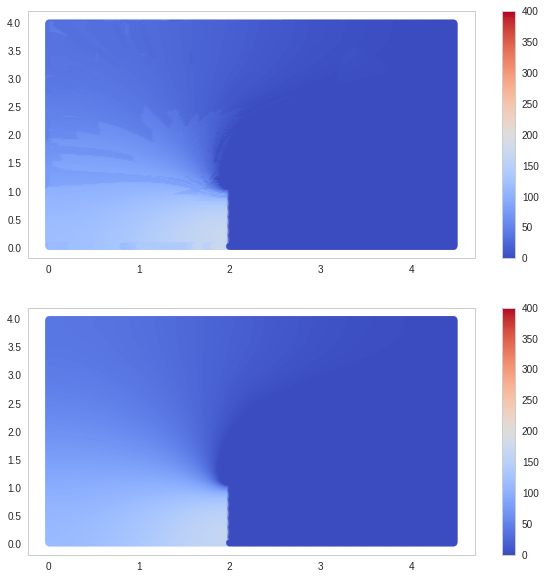

In [61]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.scatter(data['0.71'].ccx,data['0.71'].ccy,c=clf.predict(datainput),cmap='coolwarm',vmax=400,vmin=0)
plt.colorbar()
plt.subplot(212)
plt.scatter(data['0.71'].ccx,data['0.71'].ccy,c=dataoutput,cmap='coolwarm',vmax=400,vmin=0)
plt.colorbar()